## Read data

In [3]:
import json
import numpy as np
import cv2
import tensorflow as tf

with open('ex.json') as f:
    data_raw = json.load(f)
    
im_raw = np.array(cv2.imread('ex.jpg', 0),dtype=np.int64)

## Crop image

In [4]:
def rectify_coord(x):
    return max(x,0)

crop_rect = [data_raw['crop']['start']['x'],data_raw['crop']['start']['y'],data_raw['crop']['end']['x'],data_raw['crop']['end']['y']]
crop_rect = [rectify_coord(x) for x in crop_rect]
im = im_raw[crop_rect[1]:crop_rect[3],crop_rect[0]:crop_rect[2]]

## Filter bounding boxes 

In [5]:
bbox_raw = data_raw['textAnnotations']
count = 0
bboxes_obj = {}
bboxes = []

for i in bbox_raw:
    if bbox_raw[i]['cell_id'] != None:
        bboxes_obj[count] = bbox_raw[i]
        txt = bbox_raw[i]['description']
        # Update coordinates
        xmin = bbox_raw[i]['boundingPoly']['vertices'][0]['x'] - crop_rect[0]
        ymin = bbox_raw[i]['boundingPoly']['vertices'][0]['y'] - crop_rect[1]
        xmax = bbox_raw[i]['boundingPoly']['vertices'][3]['x'] - crop_rect[0]
        ymax = bbox_raw[i]['boundingPoly']['vertices'][3]['y'] - crop_rect[1]
        bboxes.append([len(txt),txt,xmin,ymin,xmax,ymax])
        count+=1
        
bboxes = np.array(bboxes)

## Convert index to matrix

In [6]:
dim = len(bboxes_obj)
cellmatrix = np.zeros([dim,dim])
rowmatrix = np.zeros([dim,dim])
colmatrix = np.zeros([dim,dim])

for r in range(dim):
    for c in range(dim):
        # BB sharing the same cell
        if bboxes_obj[r]['cell_id'] == bboxes_obj[c]['cell_id']:
            cellmatrix[r,c] = 1
        # BB sharing the same row
        elif (bboxes_obj[r]['row_index'] <= bboxes_obj[c]['row_index']) or (bboxes_obj[c]['row_index'] <= bboxes_obj[r]['row_index']):
            rowmatrix[r,c] = 1
        # BB sharing the same column
        elif (bboxes_obj[r]['column_index'] <= bboxes_obj[c]['column_index']) or (bboxes_obj[c]['column_index'] <= bboxes_obj[r]['column_index']):
            rowmatrix[r,c] = 1

In [7]:
def pad_with_zeros(arr,shape):                 #will pad the input array with zeros to make it equal to 'shape'
    dummy=np.zeros(shape,dtype=np.int64)
    dummy[:arr.shape[0],:arr.shape[1]]=arr
    return dummy

def convert_to_int(arr):                      #simply converts array to a string
    return [int(val) for val in arr]

def str_to_int(string):                           #converts each character in a word to equivalent int
    max_length_of_word = 50
    intsarr=np.array([ord(chr) for chr in string])
    padded_arr=np.zeros(shape=(max_length_of_word),dtype=np.int64)
    padded_arr[:len(intsarr)]=intsarr
    return padded_arr

def generate_tf_record(im, cellmatrix, rowmatrix, colmatrix, arr, tablecategory, num_of_max_vertices, max_length_of_word):
        '''This function generates tfrecord files using given information'''
        cellmatrix = pad_with_zeros(cellmatrix,(num_of_max_vertices, num_of_max_vertices))
        colmatrix = pad_with_zeros(colmatrix, (num_of_max_vertices, num_of_max_vertices))
        rowmatrix = pad_with_zeros(rowmatrix, (num_of_max_vertices, num_of_max_vertices))
        
        im = im.astype(np.int64)
        img_height, img_width = im.shape
        
        words_arr = arr[:, 1].tolist()
        no_of_words = len(words_arr)

        lengths_arr = convert_to_int(arr[:, 0])
        vertex_features = np.zeros(shape=(num_of_max_vertices, 5),dtype=np.int64)
        lengths_arr = np.array(lengths_arr).reshape(len(lengths_arr),-1)
        sample_out = np.array(np.concatenate((arr[:,2:],lengths_arr),axis=1))
        vertex_features[:no_of_words,:]=sample_out

        #vertex_text=np.chararray(shape=(self.num_of_max_vertices,self.max_length_of_word))
        #vertex_text[:no_of_words,:]=list(map(self.str_to_chars, words_arr))
        #vertex_text=words_arr+[""]*(self.num_of_max_vertices-len(words_arr))

        vertex_text = np.zeros((num_of_max_vertices, max_length_of_word), dtype=np.int64)
        vertex_text[:no_of_words]=np.array(list(map(str_to_int,words_arr)))

        
        feature = dict()
        feature['image'] = tf.train.Feature(float_list=tf.train.FloatList(value=im.astype(np.float32).flatten()))
        feature['global_features'] = tf.train.Feature(float_list=tf.train.FloatList(value=np.array([img_height, img_width,no_of_words,tablecategory]).astype(np.float32).flatten()))
        feature['vertex_features'] = tf.train.Feature(float_list=tf.train.FloatList(value=vertex_features.astype(np.float32).flatten()))
        feature['adjacency_matrix_cells'] = tf.train.Feature(int64_list=tf.train.Int64List(value=cellmatrix.astype(np.int64).flatten()))
        feature['adjacency_matrix_cols'] = tf.train.Feature(int64_list=tf.train.Int64List(value=colmatrix.astype(np.int64).flatten()))
        feature['adjacency_matrix_rows'] = tf.train.Feature(int64_list=tf.train.Int64List(value=rowmatrix.astype(np.int64).flatten()))
        feature['vertex_text'] = tf.train.Feature(int64_list=tf.train.Int64List(value=vertex_text.astype(np.int64).flatten()))

        all_features = tf.train.Features(feature=feature)

        seq_ex = tf.train.Example(features=all_features)
        return seq_ex

In [8]:
num_of_max_vertices = 900
max_length_of_word = 50
seq_ex = generate_tf_record(im, cellmatrix, rowmatrix, colmatrix, bboxes, 1, num_of_max_vertices, max_length_of_word)

In [12]:
options = tf.compat.v1.io.TFRecordOptions(tf.compat.v1.io.TFRecordCompressionType.GZIP)
with tf.io.TFRecordWriter('tfrecords/ex.tfrecord',options=options) as writer:
    writer.write(seq_ex.SerializeToString())

# Create dataset

In [12]:
import pandas as pd
from urllib.request import urlopen

df = pd.read_csv('dump')


In [13]:
def url_to_image(url):
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    resp = urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_GRAYSCALE)
    image = np.array(image, dtype=np.int64)
    return image

In [18]:
num_of_max_vertices = 900
max_length_of_word = 50
options = tf.compat.v1.io.TFRecordOptions(tf.compat.v1.io.TFRecordCompressionType.GZIP)

url_prefix = 'https://static.openfoodfacts.org/images/products'
bad_json_cnt = 0
bad_cnt = 0

for index, row in df.iterrows():
    print("Processing "+str(index)+"/"+str(len(df)))
    try:
        # load raw data
        data_raw = json.loads(row['data'].replace("\'", "\"").replace("None","null"))['annotation']
        if data_raw['dataQuality'] == "perfect-data":
            # load raw image
            source_image = row['source_image']
            im_raw = url_to_image(url_prefix+source_image) 
            # crop image
            crop_rect = [data_raw['crop']['start']['x'],data_raw['crop']['start']['y'],data_raw['crop']['end']['x'],data_raw['crop']['end']['y']]
            crop_rect = [rectify_coord(x) for x in crop_rect]
            im = im_raw[crop_rect[1]:crop_rect[3],crop_rect[0]:crop_rect[2]]

            # filter bounding boxes
            bbox_raw = data_raw['textAnnotations']
            bboxes_obj = {}
            bboxes = []
            count = 0
            for i in bbox_raw:
                if bbox_raw[i]['cell_id'] != None:
                    bboxes_obj[count] = bbox_raw[i]
                    txt = bbox_raw[i]['description']
                    # Update coordinates
                    xmin = bbox_raw[i]['boundingPoly']['vertices'][0]['x'] - crop_rect[0]
                    ymin = bbox_raw[i]['boundingPoly']['vertices'][0]['y'] - crop_rect[1]
                    xmax = bbox_raw[i]['boundingPoly']['vertices'][3]['x'] - crop_rect[0]
                    ymax = bbox_raw[i]['boundingPoly']['vertices'][3]['y'] - crop_rect[1]
                    bboxes.append([len(txt),txt,xmin,ymin,xmax,ymax])
                    count+=1
            bboxes = np.array(bboxes)
            
            # Convert index to matrix
            dim = len(bboxes_obj)
            cellmatrix = np.zeros([dim,dim])
            rowmatrix = np.zeros([dim,dim])
            colmatrix = np.zeros([dim,dim])
            
            for r in range(dim):
                for c in range(dim):
                    # BB sharing the same cell
                    if bboxes_obj[r]['cell_id'] == bboxes_obj[c]['cell_id']:
                        cellmatrix[r,c] = 1
                    # BB sharing the same row
                    if (bboxes_obj[r]['row_index'] <= bboxes_obj[c]['row_index']) or (bboxes_obj[c]['row_index'] <= bboxes_obj[r]['row_index']):
                        rowmatrix[r,c] = 1
                    # BB sharing the same column
                    if (bboxes_obj[r]['column_index'] <= bboxes_obj[c]['column_index']) or (bboxes_obj[c]['column_index'] <= bboxes_obj[r]['column_index']):
                        rowmatrix[r,c] = 1
                        
            # write to tfrecord
            seq_ex = generate_tf_record(im, cellmatrix, rowmatrix, colmatrix, bboxes, 1, num_of_max_vertices, max_length_of_word)
            with tf.io.TFRecordWriter('tfrecords/'+str(row['barcode'])+'.tfrecord',options=options) as writer:
                writer.write(seq_ex.SerializeToString())
                
            
        else:
            bad_cnt += 1
    except:
        bad_json_cnt += 1
        print("Cannot convert to json")

Processing 0/167
Cannot convert to json
Processing 1/167
Processing 2/167
Processing 3/167
Processing 4/167
Cannot convert to json
Processing 5/167
Processing 6/167
Processing 7/167
Cannot convert to json
Processing 8/167
Processing 9/167
Processing 10/167
Processing 11/167
Processing 12/167
Processing 13/167
Cannot convert to json
Processing 14/167
Processing 15/167
Processing 16/167
Processing 17/167
Processing 18/167
Processing 19/167
Processing 20/167
Processing 21/167
Cannot convert to json
Processing 22/167
Cannot convert to json
Processing 23/167
Processing 24/167
Processing 25/167
Processing 26/167
Processing 27/167
Cannot convert to json
Processing 28/167
Cannot convert to json
Processing 29/167
Processing 30/167
Processing 31/167
Cannot convert to json
Processing 32/167
Cannot convert to json
Processing 33/167
Cannot convert to json
Processing 34/167
Processing 35/167
Processing 36/167
Processing 37/167
Processing 38/167
Processing 39/167
Processing 40/167
Cannot convert to j

In [19]:
print(bad_cnt)
print(bad_json_cnt)

31
51


# Visualize adjacency matrix

In [83]:
data_raw = json.loads(df['data'][1].replace("\'", "\"").replace("None","null"))['annotation']

source_image = df['source_image'][1]
im_raw = url_to_image(url_prefix+source_image) 
# crop image
crop_rect = [data_raw['crop']['start']['x'],data_raw['crop']['start']['y'],data_raw['crop']['end']['x'],data_raw['crop']['end']['y']]
crop_rect = [rectify_coord(x) for x in crop_rect]
im = im_raw[crop_rect[1]:crop_rect[3],crop_rect[0]:crop_rect[2]]

bbox_raw = data_raw['textAnnotations']
count = 0
bboxes_obj = {}
bboxes = []

for i in bbox_raw:
    if bbox_raw[i]['cell_id'] != None:
        bboxes_obj[count] = bbox_raw[i]
        txt = bbox_raw[i]['description']
        # Update coordinates
        xmin = bbox_raw[i]['boundingPoly']['vertices'][0]['x'] - crop_rect[0]
        ymin = bbox_raw[i]['boundingPoly']['vertices'][0]['y'] - crop_rect[1]
        xmax = bbox_raw[i]['boundingPoly']['vertices'][3]['x'] - crop_rect[0]
        ymax = bbox_raw[i]['boundingPoly']['vertices'][3]['y'] - crop_rect[1]
        bboxes.append([len(txt),txt,xmin,ymin,xmax,ymax])
        count+=1
        
bboxes = np.array(bboxes)

dim = len(bboxes_obj)
cellmatrix = np.zeros([dim,dim])
rowmatrix = np.zeros([dim,dim])
colmatrix = np.zeros([dim,dim])

for r in range(dim):
    for c in range(dim):
        # BB sharing the same cell
        if bboxes_obj[r]['cell_id'] == bboxes_obj[c]['cell_id']:
            cellmatrix[r,c] = 1
        # BB sharing the same row
        if (set(bboxes_obj[r]['row_index']).issubset(set(bboxes_obj[c]['row_index']))) or (set(bboxes_obj[c]['row_index']).issubset(set(bboxes_obj[r]['row_index']))):
            rowmatrix[r,c] = 1
        # BB sharing the same column
        if (set(bboxes_obj[r]['column_index']).issubset(set(bboxes_obj[c]['column_index']))) or (set(bboxes_obj[c]['column_index']).issubset(set(bboxes_obj[r]['column_index']))):
            colmatrix[r,c] = 1

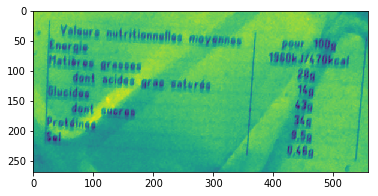

In [84]:
import matplotlib.pyplot as plt

imgplot = plt.imshow(im)
plt.show()

In [85]:
df_visu = pd.DataFrame(rowmatrix)
df_visu.columns = bboxes[:,1]
df_visu.index = bboxes[:,1]

In [86]:
df_visu

,Energie,Valsurs,nutritionnelles,Sel,moyennes,Matibres,1960k,pour,100g,Protdings,...,sueres,acides,gras,saturés,0.46g,"9,5g",349,439,28g,14g
Energie,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Valsurs,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nutritionnelles,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sel,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
moyennes,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Matibres,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1960k,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
pour,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100g,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Protdings,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
